# This is a language analysis notebook.
We will be comparing articles from Bulbapedia and a few other selected texts to English, French and German.

## Proposed similarity function

Below is an implementation of a proposed language confidence function that compares a text a dictionary of most common words in a language.  
For each word in the text, let $p$ be its frequency in the text and $q$ its frequency in the dictionary, both being values in range $[0, 1]$.  
That word's score is defined as $(p-q)^2$ if the word was found in the language dictionary. If not, the score is instead equal to $max(p^2, (1-p)^2)$, being the supremum of $(p-q)^2$ for all possible values of our unknown $q$.  
Each word's score denotes a degree of misalignment between the text and the language. The average of all word scores $A$ can be interpreted as the entire text's misalignment. Naturally, the confidence (similarity) score will be equal to $1-A$ (the less misalignment, the higher the score).

In [15]:
def lang_confidence_score(word_counts: dict[str, float], language_words_with_frequency: dict[str, float]) -> float:
    if(len(word_counts) == 0):
        return 1
    number_of_words = 0
    for val in word_counts.items():
        number_of_words += val[1]
    deviation = 0
    for word in word_counts:
        if(word not in word_counts or word not in language_words_with_frequency): 
            # Dictionary miss - we impose the most severe penalty.
            deviation += max(word_counts[word] / number_of_words, 1 - word_counts[word] / number_of_words)**2
        else:
            # Word found in dictionary - we impose penalty based on difference of frequency in text and frequency in dictionary.
            deviation += (word_counts[word] / number_of_words - language_words_with_frequency[word])**2
    return 1 - deviation / len(word_counts)

We use the wordfreq package to select 1000 most frequent words in each language.

In [16]:
import wordfreq 

def create_lang_dict(size, language):
    words = wordfreq.top_n_list(language, size, wordlist='best')
    d = {w: wordfreq.word_frequency(w, language) for w in set(words)}
    return d


en_dict = create_lang_dict(1000, 'en')
fr_dict = create_lang_dict(1000, 'fr')
de_dict = create_lang_dict(1000, 'de')

## Large Bulbapedia article (Ash Ketchum)
We will use the article about the Pokemon Series main character Ash Ketchum as a representative.

In [17]:
import json
from pathlib import Path

p = Path('./word-counts.json')

if(p.exists()):
    p.unlink()

%run wikiscraper.py --count-words Ash

with open('./word-counts.json', 'r') as file:
    large_article = json.load(file)

Output below was generated using an article originally published on https://bulbapedia.bulbagarden.net/wiki.
It is licensed under BY-NC-SA.



## Interesting article
We wish to highlight some differences between English and Bulbapedia. An article with a list of Pokemon names was chosen after a selection process.

In [18]:
p = Path('./word-counts.json')

lowest_score = 1

if(p.exists()):
    p.unlink()

%run wikiscraper.py --count-words 'List of Pokémon by weight'

with open('./word-counts.json', 'r') as file:
    interesting_article = json.load(file) 
        
# Verify that the score is low

print(lang_confidence_score(interesting_article, en_dict))
print(lang_confidence_score(interesting_article, fr_dict))
print(lang_confidence_score(interesting_article, de_dict))

Output below was generated using an article originally published on https://bulbapedia.bulbagarden.net/wiki.
It is licensed under BY-NC-SA.

0.08531425567674877
0.022676039568453765
0.019085249158489637


# Classic literature
We chose "Frankenstein", "Faust" and "Candide" as texts representative of English, German and French.

In [19]:
def text_to_dict(book_path):
    with open(book_path, 'r') as file:
        text_content = file.read()
    text_content = ''.join(list(map(lambda c: c.lower() if (c.isalpha() or c == ' ') else ' ', text_content)))
    
    counter: dict[str, int] = {}
    for word in text_content.split():
        counter[word] = counter.get(word, 0) + 1
    return counter

In [20]:
frankenstein_dict = text_to_dict('./frankenstein.txt')
faust_dict = text_to_dict('./faust.txt')
candide_dict = text_to_dict('./candide.txt')

# Comparison chart
Below is a chart comparing our texts to each language's $k$ most frequent words.

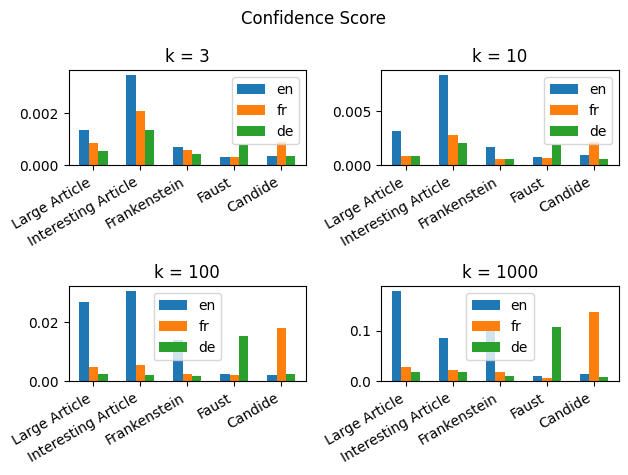

In [21]:
import numpy as np
import matplotlib.pyplot as plt

texts = [large_article, interesting_article, frankenstein_dict, faust_dict, candide_dict]
labels = ['Large Article', 'Interesting Article', 'Frankenstein', 'Faust', 'Candide']
languages = ['en', 'fr', 'de']

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for idx, k in enumerate([3, 10, 100, 1000]):
    matrix = np.empty([len(texts), len(languages)])
    for i, t in enumerate(texts):
        for j, l in enumerate(languages):
            matrix[i][j] = lang_confidence_score(t, create_lang_dict(k, l))

    x = np.arange(len(texts))
    width = 0.2
    ax = axes[idx]
        
    for j, l in enumerate(languages):
        ax.bar(x + j*width, matrix[:, j], width, label=l)
        
    ax.set_xticks(x + width)
    ax.set_xticklabels(labels, rotation = 30, ha='right')
    ax.set_title(f'k = {k}')
    ax.legend()

fig.suptitle('Confidence Score')
plt.tight_layout()
plt.show()



# Results
## Effectiveness of our function
We can see that the proposed function is somewhat accurate in identifying the language of the wiki.
For all considered $k$'s texts score significantly higher with the dictionary of the language they are written in.

The scored assigned by our function should be monotonic with respect to $k$ (the larger the $k$, the less dictionary misses).
This is clearly confirmed by our examples, as all scores increase significantly with large $k$'s.

Even though the assigned scores are relatively low, the function succeeds at effectively identyfing the language of our text - even for $k$ as low as 10.
## Specifics of considered languages
All three language dictionaries perform similarly despite the confidence function relying on the inflection of the words to correctly identify matches. 
However, German and Faust slightly lag behind with their assigned score - this is possibly due to declation.
Despite the above, the chart alone does not provide enough information to unambigiously state which language has the most word inflection - the results are simply too similar.
## Pokemon lingo vs English language
Finding an article with a relatively low English score was difficult. Scraping random articles proved to be ineffective, so the  best guess was an article with a list of Pokemons. 

Even though it largely consists of Pokemon names (which are not in the English dictionary), its score for $k=1000$ is only around 2 times smaller than the flagship article about Ash Ketchum, which consists of long paragraphs written in (mostly) conventional English.  